# OpenCL Heterogeneous Mapping

This notebook contains the experiments for Case Study A - using deep learning to predict the optimal device mapping for OpenCL kernels, without hand engineered features.

## 1. Runtime Data

We use the runtime data from our CGO'17 paper [1]. The code to reproduce those experiments can be found in this, artifact evaluated [GitHub repository](https://github.com/ChrisCummins/paper-synthesizing-benchmarks).

> [1] Cummins, C., Petoumenos, P., Zang, W., & Leather, H. (2017). [Synthesizing Benchmarks for Predictive Modeling](http://chriscummins.cc/pub/2017-cgo.pdf). In CGO. IEEE.

The runtime data comes from two plaforms. AMD:

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5)

pd.read_csv("../data/case-study-a/cgo17-amd.csv")

,Unnamed: 0,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,oracle,runtime_cpu,runtime_gpu,src,seq
0,0,amd-app-sdk-3.0-BinomialOption-binomial_options,default,98,8,13,11,2,0,2048,255,GPU,3.291073,1.443983,"__kernel void A(int a, const __global float4* ...","[129 129 129 ..., 0 127 0]"
1,1,amd-app-sdk-3.0-BitonicSort-bitonicSort,default,12,2,6,0,6,0,131072,256,CPU,0.121940,0.279521,"__kernel void A(__global uint* a, const uint b...","[129 129 129 ..., 0 127 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,678,shoc-1.1.5-Stencil2D-StencilKernel,default,144,7,16,12,3,0,71647488,256,GPU,17.866730,16.666380,"__kernel void A(__global float* a, __global fl...","[ 1 96 1 ..., 127 0 127]"
679,679,shoc-1.1.5-Triad-Triad,default,2,0,3,0,3,0,117440512,128,CPU,876.457180,968.494606,"__kernel void A(__global const float* a, __glo...","[129 129 129 ..., 0 127 0]"


and NVIDIA:

In [2]:
pd.read_csv("../data/case-study-a/cgo17-nvidia.csv")

,Unnamed: 0,benchmark,dataset,comp,rational,mem,localmem,coalesced,atomic,transfer,wgsize,oracle,runtime_cpu,runtime_gpu,src,seq
0,0,amd-app-sdk-3.0-BinomialOption-binomial_options,default,98,8,13,11,2,0,2048,255,GPU,3.291073,0.152038,"__kernel void A(int a, const __global float4* ...","[129 129 129 ..., 0 127 0]"
1,1,amd-app-sdk-3.0-BitonicSort-bitonicSort,default,12,2,6,0,6,0,131072,256,GPU,0.121940,0.057834,"__kernel void A(__global uint* a, const uint b...","[129 129 129 ..., 0 127 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,678,shoc-1.1.5-Stencil2D-StencilKernel,default,144,7,16,12,3,0,71647488,256,CPU,17.866730,48.047807,"__kernel void A(__global float* a, __global fl...","[ 1 96 1 ..., 127 0 127]"
679,679,shoc-1.1.5-Triad-Triad,default,2,0,3,0,3,0,117440512,128,CPU,876.457180,3184.516221,"__kernel void A(__global const float* a, __glo...","[129 129 129 ..., 0 127 0]"


## 2. Predictive Models

We define a base class for implementing predictive models for heterogeneous mapping:

In [3]:
import numpy as np
from clgen import atomizer as clgen

class HeterogemeousMappingModel(object):
    """
    A model for predicting OpenCL heterogeneous device mappings.
    
    Attributes
    ----------
    __name__ : str
        Model name
    __basename__ : str
        Shortened name, used for files
    """
    __name__ = None
    __basename__ = None
    
    def init(self, seed: int) -> None:
        """
        Initialize the model.
        
        Do whatever is required to setup a new heterogeneous model here.
        This method is called prior to training and predicting.
        This method may be omitted if no initial setup is required.
        
        Parameters
        ----------
        seed : int
            The seed value used to reproducible results. May be 'None',
            indicating that no seed is to be used.
        """
        pass
    
    def save(self, outpath: str) -> None:
        """
        Save model state.
        
        This must capture all of the relevant state of the model. It is up
        to implementing classes to determine how best to save the model.
        
        Parameters
        ----------
        outpath : str
            The path to save the model state to.
        """
        raise NotImplementedError
    
    def restore(self, inpath: str) -> None:
        """
        Load a trained model from file.
        
        This is called in place of init() if a saved model file exists. It
        must restore all of the required model state.
    
        Parameters
        ----------
        inpath : str
            The path to load the model from. This is the same path as
            was passed to save() to create the file.
        """
        raise NotImplementedError
        
    def train(self, df: pd.DataFrame, features: np.array, sequences: np.array,
              y: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        """
        Train a model.
        
        Parameters
        ----------
        df : pd.DataFrame
            The platform dataframe.
        
        features : np.array
            An array of feature vectors of shape (n,4).
        
        sequences : np.array
            An array of encoded source code sequences of shape (n,seq_length).

        y : np.array
            An array of optimal device mappings of shape (n,1).
        
        y_1hot : np.array
            An array of optimal device mappings of shape (n,2), in 1-hot encoding.
            
        verbose: bool, optional
            Whether to print verbose status messages during training.
        """
        raise NotImplementedError

    def predict(self, features: np.array, sequences: np.array, y: np.array, y_1hot: np.array) -> np.array:
        """
        Make predictions for programs.
        
        Parameters
        ----------
        features : np.array
            An array of feature vectors of shape (n,4).
        
        sequences : np.array
            An array of encoded source code sequences of shape (n,seq_length).

        y : np.array
            An array of optimal device mappings of shape (n,1).
        
        y_1hot : np.array
            An array of optimal device mappings of shape (n,2), in 1-hot encoding.
            
        Returns
        -------
        np.array
            Predicted 'y' values (optimal device mappings) with shape (n,1).
        """
        raise NotImplementedError

We also define some utility code which we will use later:

In [4]:
from typing import List

def platform2str(platform: str) -> str:
    """ get full platform name """
    if platform == "amd":
        return "AMD Tahiti 7970"
    elif platform == "nvidia":
        return "NVIDIA GTX 970"
    else:
        raise LookupException
        
def escape_suite_name(g: str) -> str:
    """ format benchmark suite name for display """
    c = g.split('-')
    if c[0] == "amd" or c[0] == "nvidia":
        return c[0].upper() + " SDK"
    if c[0] == "npb" or c[0] == "shoc":
        return c[0].upper()
    elif c[0] == "parboil" or c[0] == "polybench" or c[0] == "rodinia":
        return c[0].capitalize()
    else:
        raise LookupError


def escape_benchmark_name(g: str) -> str:
    """escape benchmark name for display"""
    c = g.split('-')
    return escape_suite_name(c[0]).split()[0] + "." + c[-2]

    
def grewe_features(df: pd.DataFrame) -> np.array:
    """ extract Grewe et al. feature vector from runtime data """
    return np.array([
            (df["transfer"].values / (df["comp"].values + df["mem"].values)),  # F1
            (df["coalesced"].values / df["mem"].values),  # F2
            ((df["localmem"].values / df["mem"].values) * df["wgsize"].values),  # F3
            (df["comp"].values / df["mem"].values),  # F4
        ]).T

def auxiliary_inputs(df: pd.DataFrame) -> np.array:
    """ get dsize and wgsize auxiliary inputs """
    return np.array([
        df["transfer"].values,
        df["wgsize"].values,
    ]).T

def encode_1hot(y: np.array) -> np.array:
    """ 1-hot encode labels """
    labels = np.vstack([np.expand_dims(x, axis=0) for x in y])
    l2 = [x[0] for x in labels]
    l1 = [not x for x in l2]
    return np.array(list(zip(l1, l2)), dtype=np.int32)

def encode_srcs(srcs: List[str]) -> np.array:
    """ encode and pad source code for learning """
    from keras.preprocessing.sequence import pad_sequences
    
    seqs = [atomizer.atomize(src) for src in srcs]
    pad_val = atomizer.vocab_size
    encoded = np.array(pad_sequences(seqs, maxlen=1024, value=pad_val))
    return np.vstack([np.expand_dims(x, axis=0) for x in encoded])

## 3. Experimental Methodology

Random seed for reproducible results:

In [5]:
seed = 204

The source encoder (see the *'Language Model.ipynb'* notebook for details):

In [6]:
srcs = '\n'.join(pd.read_csv("../data/case-study-a/cgo17-amd.csv")['src'].values)
atomizer = clgen.GreedyAtomizer.from_text(srcs)
atomizer

GreedyAtomizer[128 tokens]

Our method to evaluate a predictive model using 10-fold cross-validation:

In [7]:
from labm8 import fs

def evaluate(model: HeterogemeousMappingModel) -> pd.DataFrame:
    """
    Evaluate a model.
    
    Performs 10-fold cross-validation of the model's effectiveness at predicting
    OpenCL device mappings. Results are cached.
    
    Parameters
    ----------
    model : HeterogeneousMappingModel
        The predictive model to evaluate.
        
    Returns
    -------
    pd.Dataframe
        Evaluation results.
    """
    from sklearn.model_selection import StratifiedKFold
    from progressbar import ProgressBar
    
    progressbar = [0, ProgressBar(max_value=10*2)]

    data = []
    for i, platform in enumerate(["amd", "nvidia"]):
        platform_name = platform2str(platform)

        # load runtime data
        df = pd.read_csv(f"../data/case-study-a/cgo17-{platform}.csv")
        
        sequences = None  # defer sequence encoding until needed (it's expensive)
        
        # values used for training & predictions
        features = grewe_features(df)
        aux_in = auxiliary_inputs(df)
        
        # optimal mappings
        y = np.array([1 if x == "GPU" else 0 for x in df["oracle"].values])
        y_1hot = encode_1hot(y)
        
        # 10-fold cross-validation
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        for j, (train_index, test_index) in enumerate(kf.split(features, y)):
            model_path = f"../data/case-study-a/models/{model.__basename__}-{platform}-{j}.model"
            predictions_path = f"../data/case-study-a/predictions/{model.__basename__}-{platform}-{j}.result"
            
            if fs.exists(predictions_path):
                # load result from cache
                with open(predictions_path, 'rb') as infile:
                    p = pickle.load(infile)
            else:
                if sequences is None:  # encode source codes if needed
                    sequences = encode_srcs(df["src"].values)

                if fs.exists(model_path):
                    # restore trained model from cache
                    model.restore(model_path)
                else:
                    # train and cache a model
                    model.init(seed=seed)                   
                    model.train(df=df,
                                features=features[train_index],
                                aux_in=aux_in[train_index],
                                sequences=sequences[train_index],
                                y=y[train_index],
                                y_1hot=y_1hot[train_index])
                    fs.mkdir(fs.dirname(model_path))
                    model.save(model_path)

                # test model
                p = model.predict(
                    features=features[test_index],
                    aux_in=aux_in[test_index],
                    sequences=sequences[test_index],
                    y=y[test_index],
                    y_1hot=y_1hot[test_index],
                )
    
                # cache results
                fs.mkdir(fs.dirname(predictions_path))
                with open(predictions_path, 'wb') as outfile:
                    pickle.dump(p, outfile)

            # benchmarks
            benchmarks = df['benchmark'].values[test_index]
            # oracle device mappings
            o = y[test_index]
            # whether predictions were correct or not
            correct = p == o
            # runtimes of baseline mapping (CPU on AMD, GPU on NVIDIA)
            zero_r_dev = "runtime_cpu" if platform == "amd" else "runtime_gpu"
            zer_r_runtimes = df[zero_r_dev][test_index]
            # speedups of predictions
            runtimes = df[['runtime_cpu', 'runtime_gpu']].values[test_index]
            p_runtimes = [r[p_] for p_, r in zip(p, runtimes)]
            p_speedup = zer_r_runtimes / p_runtimes
    
            # sanity check
            assert(len(benchmarks) == len(o) == len(correct) == len(p) == len(p_speedup))

            # record results
            for benchmark_, o_, p_, correct_, p_speedup_ in zip(benchmarks, o, p, correct, p_speedup):
                data.append({
                    "Model": model.__name__,
                    "Platform": platform_name,
                    'Benchmark': escape_benchmark_name(benchmark_),
                    'Benchmark Suite': escape_suite_name(benchmark_),
                    "Oracle Mapping": o_,
                    "Predicted Mapping": p_,
                    "Correct?": correct_,
                    "Speedup": p_speedup_,
                })
            
            # update progress bar
            progressbar[0] += 1
            progressbar[1].update(progressbar[0])

    return pd.DataFrame(
        data, index=range(1, len(data)+1), columns=[
            "Model",
            "Platform",
            "Benchmark",
            "Benchmark Suite", 
            "Oracle Mapping", 
            "Predicted Mapping", 
            "Correct?", 
            "Speedup"
        ])

### 3.1. Static Mapping

A static mapping selects the device which is most frequently optimal for that platform, i.e. it is the upper bound of performance which can be achieved without a heuristic. We use this as a baseline to compare predictive models against:

In [8]:
import pickle

class StaticMapping(HeterogemeousMappingModel):
    __name__ = "Static mapping"
    __basename__ = "static"
    
    def init(self, seed: int): return self
    
    def save(self, outpath):
        with open(outpath, "wb") as outfile:
            pickle.dump(self.model, outfile)

    def restore(self, inpath):
        with open(inpath, "rb") as infile:
            self.model = pickle.load(infile)

    def train(self, df=None, **train):
        from collections import Counter
        
        # select the Zero-R device: the most frequently optimal device
        zero_r_device = Counter(df['oracle']).most_common(1)[0][0]
        self.model = 1 if zero_r_device == "GPU" else 0

    def predict(self, **test):
        if self.model:
            return np.ones(len(test["y"])).astype(np.int32)
        else:
            return np.zeros(len(test["y"])).astype(dtype=np.int32)

In [9]:
import sys

pd.set_option('display.max_rows', 14)

print("Evaluating static mapping ...", file=sys.stderr)
baseline = evaluate(StaticMapping())
baseline.groupby(['Platform', 'Benchmark Suite'])['Platform', 'Correct?', 'Speedup'].mean()

Evaluating static mapping ...
 70% (14 of 20) |#####################         | Elapsed Time: 0:00:00 ETA:  0:00:00

Correct?  Speedup
Platform        Benchmark Suite                   
AMD Tahiti 7970 AMD SDK          0.625000      1.0
                NPB              0.618596      1.0
                NVIDIA SDK       0.083333      1.0
                Parboil          0.473684      1.0
                Polybench        0.074074      1.0
                Rodinia          0.548387      1.0
                SHOC             0.729167      1.0
NVIDIA GTX 970  AMD SDK          0.937500      1.0
                NPB              0.622391      1.0
                NVIDIA SDK       0.583333      1.0
                Parboil          0.315789      1.0
                Polybench        0.555556      1.0
                Rodinia          0.387097      1.0
                SHOC             0.083333      1.0

Summary of results. The *Correct?* column shows model accuracy. In the paper we report that the static mapping is accurate for **58.8%** of cases on AMD and **56.9%** of cases on NVIDIA:

In [10]:
baseline.groupby(['Platform'])['Platform', 'Correct?', 'Speedup'].mean()

,Correct?,Speedup
Platform,,
AMD Tahiti 7970,0.588235,1.0
NVIDIA GTX 970,0.569118,1.0


### 3.2. Grewe et al. Model

The Grewe et al. predictive model uses decision trees and hand engineered features to predict optimal device mapping, described in publication:

> [2] Grewe, D., Wang, Z., & O’Boyle, M. (2013). [Portable Mapping of Data Parallel Programs to OpenCL for Heterogeneous Systems](http://www.ece.neu.edu/groups/nucar/NUCARTALKS/cgo2013-grewe.pdf). In CGO. IEEE.

In [11]:
class Grewe(HeterogemeousMappingModel):
    __name__ = "Grewe et al."
    __basename__ = "grewe"
    
    def init(self, seed: int):
        from sklearn.tree import DecisionTreeClassifier

        self.model = DecisionTreeClassifier(
            random_state=seed, splitter="best",
            criterion="entropy", max_depth=5,
            min_samples_leaf=5)
        return self
    
    def save(self, outpath):
        with open(outpath, "wb") as outfile:
            pickle.dump(self.model, outfile)

    def restore(self, inpath):
        with open(inpath, "rb") as infile:
            self.model = pickle.load(infile)
        
    def train(self, **train):
        self.model.fit(train["features"], train["y"])

    def predict(self, **test):
        return self.model.predict(test["features"])

In [12]:
print("Evaluating Grewe et al. ...", file=sys.stderr)
grewe = evaluate(Grewe())
grewe.groupby(['Platform', 'Benchmark Suite'])['Platform', 'Correct?', 'Speedup'].mean()

Evaluating Grewe et al. ...
 65% (13 of 20) |###################           | Elapsed Time: 0:00:00 ETA:  0:00:00

Correct?    Speedup
Platform        Benchmark Suite                     
AMD Tahiti 7970 AMD SDK          0.750000   1.088049
                NPB              0.740038   2.447364
                NVIDIA SDK       0.750000   3.694169
                Parboil          0.631579   5.927718
                Polybench        0.592593  13.283587
                Rodinia          0.645161   3.355448
                SHOC             0.833333   1.024105
NVIDIA GTX 970  AMD SDK          0.625000   0.783911
                NPB              0.785579   1.270429
                NVIDIA SDK       0.416667   0.922276
                Parboil          0.263158   1.014902
                Polybench        0.592593   1.036523
                Rodinia          0.387097   0.993468
                SHOC             0.708333   1.851509

Summary of results. The *Correct?* column shows model accuracy. In the paper we report that the Grewe et al. model is accurate **73%** of cases, achieving speedups of **2.91$\times$** on AMD and **1.26$\times$** on NVIDIA:

In [13]:
grewe.groupby(['Platform'])['Platform', 'Correct?', 'Speedup'].mean()

,Correct?,Speedup
Platform,,
AMD Tahiti 7970,0.733824,2.905822
NVIDIA GTX 970,0.729412,1.264801


### 3.3. DeepTune

We predict optimal device mapping from raw source code inputs, and the
two auxiliary inputs wgsize and dsize (which cannot be obtained statically
from the program source):

In [14]:
class DeepTune(HeterogemeousMappingModel):
    __name__ = "DeepTune"
    __basename__ = "deeptune"
    
    def init(self, seed: int):
        from keras.layers import Input, Embedding, LSTM, Dense
        from keras.layers.merge import Concatenate
        from keras.layers.normalization import BatchNormalization
        from keras.models import Model

        np.random.seed(seed)
        
        # Language model. Takes as inputs source code sequences.
        code_in = Input(shape=(1024,), dtype="int32", name="code_in")
        x = Embedding(input_dim=atomizer.vocab_size + 1, input_length=1024, 
                      output_dim=64, name="embedding")(code_in)
        x = LSTM(64, implementation=1, return_sequences=True, name="lstm_1")(x)
        x = LSTM(64, implementation=1, name="lstm_2")(x)
        langmodel_out = Dense(2, activation="sigmoid")(x)
        
        # Auxiliary inputs. wgsize and dsize.
        auxiliary_inputs = Input(shape=(2,))
        
        # Heuristic model. Takes as inputs the language model,
        #   outputs 1-hot encoded device mapping
        x = Concatenate()([auxiliary_inputs, x])
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        out = Dense(2, activation="sigmoid")(x)

        self.model = Model(inputs=[auxiliary_inputs, code_in], outputs=[out, langmodel_out])
        self.model.compile(
            optimizer="adam", metrics=['accuracy'],
            loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[1., .2])
        
        return self

    def save(self, outpath):
        self.model.save(outpath)

    def restore(self, inpath):
        from keras.models import load_model
        self.model = load_model(inpath)
        
    def train(self, **train):
        self.model.fit([train["aux_in"], train["sequences"]], [train["y_1hot"], train["y_1hot"]],
                       epochs=50, batch_size=64, verbose=train["verbose"], shuffle=True)

    def predict(self, **test):
        p = np.array(self.model.predict(
            [test["aux_in"], test["sequences"]], batch_size=64, verbose=0))
        indices = [np.argmax(x) for x in p[0]]
        return indices

An overview of the DeepTune model, showing the number of parameters in each layer, used to construct Table 5 in the paper:

In [15]:
deeptune_model = DeepTune()
deeptune_model.init(seed)
deeptune_model.model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
code_in (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 1024, 64)      8256                                         
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 1024, 64)      33024                                        
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 2)             0                                            
___________________________________________________________________________________________

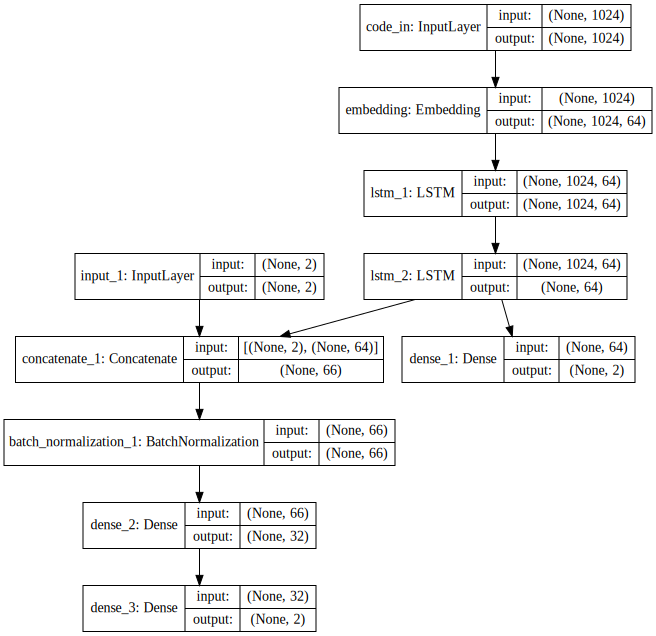

In [16]:
def isnotebook():
    # written by @mtd http://stackoverflow.com/a/39662359
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':  # Jupyter notebook or qtconsole?
            return True
        elif shell == 'TerminalInteractiveShell':  # Terminal running IPython?
            return False
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


img = None
if isnotebook():
    from keras.utils.vis_utils import model_to_dot
    from IPython.display import SVG
    img = SVG(model_to_dot(deeptune_model.model, show_shapes=True).create(prog='dot', format='svg'))
img

In [17]:
print("Evaluating DeepTune ...", file=sys.stderr)
deeptune = evaluate(deeptune_model)
deeptune.groupby(['Platform', 'Benchmark Suite'])['Platform', 'Correct?', 'Speedup'].mean()

Evaluating DeepTune ...
 80% (16 of 20) |########################      | Elapsed Time: 0:00:00 ETA:  0:00:00

Correct?    Speedup
Platform        Benchmark Suite                     
AMD Tahiti 7970 AMD SDK          0.562500   0.846116
                NPB              0.851992   2.851700
                NVIDIA SDK       0.666667   3.669208
                Parboil          0.947368   6.403654
                Polybench        0.814815  14.065773
                Rodinia          0.741935   4.752888
                SHOC             0.833333   1.229528
NVIDIA GTX 970  AMD SDK          0.500000   0.716424
                NPB              0.836812   1.407999
                NVIDIA SDK       0.666667   1.069700
                Parboil          0.789474   1.459396
                Polybench        0.555556   1.038921
                Rodinia          0.677419   1.566724
                SHOC             0.791667   1.867671

Summary of results. The *Correct?* column shows model accuracy. In the paper we report that DeepTune is accurate for **82%** of cases, achieving speedups of **3.34$\times$** on AMD and **1.41$\times$** on NVIDIA:

In [18]:
deeptune.groupby(['Platform'])['Platform', 'Correct?', 'Speedup'].mean()

,Correct?,Speedup
Platform,,
AMD Tahiti 7970,0.836765,3.335612
NVIDIA GTX 970,0.802941,1.412222


## 4. Evaluation

Here we evaluate the quality of the models using two metrics: prediction accuracy, and performance relative to the static mapping:

### 4.1. Prediction Accuracy

In [19]:
d = []
d.append(np.append(baseline.groupby(['Platform'])['Correct?'].mean().values * 100,
                   baseline['Correct?'].mean() * 100))
d.append(np.append(grewe.groupby(['Platform'])['Correct?'].mean().values * 100,
                   grewe['Correct?'].mean() * 100))
d.append(np.append(deeptune.groupby(['Platform'])['Correct?'].mean().values * 100,
                   deeptune['Correct?'].mean() * 100))
d = np.array(d).T.reshape(3, 3)

pd.DataFrame(d, columns=['Static mapping', 'Grewe et al.', 'DeepTune'],
             index=['AMD Tahiti 7970', 'NVIDIA GTX 970', 'Average'])

,Static mapping,Grewe et al.,DeepTune
AMD Tahiti 7970,58.823529,73.382353,83.676471
NVIDIA GTX 970,56.911765,72.941176,80.294118
Average,57.867647,73.161765,81.985294


Figure 6 of the paper:

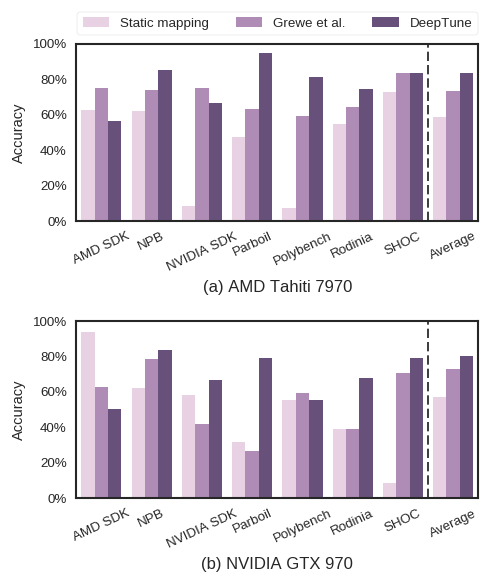

In [20]:
if isnotebook():
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    from matplotlib.ticker import FormatStrFormatter
    from labm8 import viz

    # Plotting configuration
    %matplotlib inline
    sns.set(style="ticks", color_codes=True)
    plt.style.use(["seaborn-white", "seaborn-paper"])
    matplotlib.rcParams['figure.dpi'] = 120
    
    for i, platform in enumerate(["AMD Tahiti 7970", "NVIDIA GTX 970"]):
        
        def get_accuracies(df, platform):
            """ get % accuracies for platform, aggregated by benchmark suite """
            # average by benchmark suites
            series = df[df["Platform"] == platform]\
                        .groupby(['Benchmark Suite'])['Correct?'].mean() * 100  # %
            # append average across all benchamrks
            average = pd.Series(df[df["Platform"] == platform]['Correct?'].mean() * 100,
                                index=["Average"])
            return series.append(average)

        # Aggregate data
        models, results = (StaticMapping, Grewe, DeepTune), (baseline, grewe, deeptune)
        dfs = [get_accuracies(r, platform) for r in results]

        accuracies = np.concatenate([dfs[i].values for i in range(len(dfs))])
        benchmarks = np.concatenate([dfs[i].keys().values for i in range(len(dfs))])
        models = np.concatenate([np.array([m().__name__] * len(dfs[0])) for m in models])

        benchmarks = np.append(benchmarks, "Average")

        df = pd.DataFrame([{"Benchmark": b, "Accuracy": a, "Model": m}
                           for b, a, m in zip(benchmarks, accuracies, models)])

        # Plot
        plt.subplot(2, 1, i + 1)
        palette = sns.cubehelix_palette(3, rot=.2, light=.85, dark=.35)
        ax = sns.barplot(x="Benchmark", y="Accuracy", hue="Model", palette=palette, data=df)

        # x axis
        c = chr(ord('a') + i)
        plt.xlabel(f"({c}) {platform}", fontsize=10)
        plt.setp(ax.get_xticklabels(), rotation=25)  # rotate x ticks
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

        # y axis
        plt.ylim((0, 100))    
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
        plt.ylabel("Accuracy")

        # legend
        if i == 0:
            plt.legend(loc=(0.003, 1.05), ncol=3)
            ax.get_legend().set_title("")  # no legend title
            ax.get_legend().draw_frame(True)
        elif i == 1:
            ax.legend().set_visible(False)

    viz.finalise(
        # TODO: fs.path("~/Inbox/cgo-acc.pdf"),
        figsize=(4.25, 4.8))

### 4.2. Speedups

Mean speedup:

In [21]:
d = []
d.append(np.append(baseline.groupby(['Platform'])['Speedup'].mean().values,
                   baseline['Speedup'].mean()))
d.append(np.append(grewe.groupby(['Platform'])['Speedup'].mean().values,
                   grewe['Speedup'].mean()))
d.append(np.append(deeptune.groupby(['Platform'])['Speedup'].mean().values,
                   deeptune['Speedup'].mean()))
d = np.array(d).T.reshape(3, 3)

pd.DataFrame(d, columns=['Static mapping', 'Grewe et al.', 'DeepTune'],
             index=['AMD Tahiti 7970', 'NVIDIA GTX 970', 'Average'])

,Static mapping,Grewe et al.,DeepTune
AMD Tahiti 7970,1.0,2.905822,3.335612
NVIDIA GTX 970,1.0,1.264801,1.412222
Average,1.0,2.085312,2.373917


In the paper we report geometric means of **1.18$\times$** for Grewe et al., and **1.31$\times$** for DeepTune:

In [22]:
from labm8 import math as labmath

grewe_geomean = labmath.geomean(grewe['Speedup'].values)
deeptune_geomean = labmath.geomean(deeptune['Speedup'].values)

print(f"Geometric mean of Grewe et al. {grewe_geomean:.2f}x")
print(f"Geometric mean of DeepTune {deeptune_geomean:.2f}x")

Geometric mean of Grewe et al. 1.18x
Geometric mean of DeepTune 1.31x


Figure 7 of the paper:

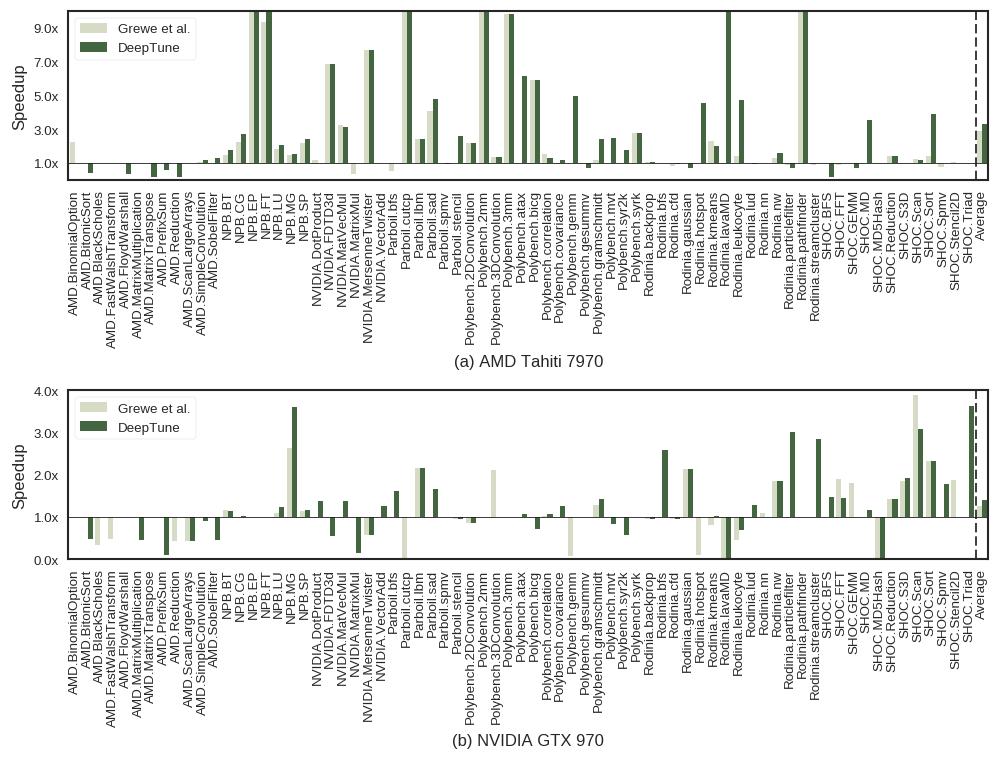

In [23]:
if isnotebook():
    for i, platform in enumerate(["AMD Tahiti 7970", "NVIDIA GTX 970"]):

        def get_speedups(df, platform):
            """ get speedups for platform, aggregated by benchmark """
            # average by benchmark
            series = df[df["Platform"] == platform]\
                .groupby(['Benchmark'])['Speedup'].mean()
            # average across all benchmarks
            average = pd.Series(df[df['Platform'] == platform]['Speedup'].mean(), index=['Average'])
            return series.append(average)

        # Aggregate data
        models, results = (Grewe, DeepTune), (grewe, deeptune)
        dfs = [get_speedups(r, platform) for r in results]

        speedups    = np.concatenate([dfs[i].values for i in range(len(dfs))])
        benchmarks  = np.concatenate([dfs[i].keys().values for i in range(len(dfs))])
        model_names = np.concatenate([np.array([m().__name__] * len(dfs[0])) for m in models])

        df = pd.DataFrame([{"Benchmark": b, "Speedup": s - 1, "Model": m}
                           for b, s, m in zip(benchmarks, speedups, model_names)])

        # Plot
        plt.subplot(2, 1, i + 1)
        palette = sns.cubehelix_palette(2, rot=1.8, light=.85, dark=.35)
        ax = sns.barplot(x="Benchmark", y="Speedup", hue="Model", palette=palette, data=df)
        c = chr(ord('a') + i)
        plt.xlabel(f"({c}) {platform}", fontsize=10)
        
        # x axis
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

        # y axis
        plt.ylim((-1, 3) if i else (-1, 9))
        plt.ylabel("Speedup", fontsize=10)

        # legend
        plt.legend(loc='upper left')
        ax.get_legend().set_title("")
        ax.get_legend().draw_frame(True)

        plt.axhline(y=0, color="k", lw=.5)  # speedup line
        ax.set_yticklabels(["{:.1f}x".format(i + 1) for i in ax.get_yticks()])
    
    viz.finalise(figsize=(8.5, 6.5))

### 4.3. Comparison to State-of-the-art

Here we directly compare performance of DeepTune against the Grewe et al. state-of-the-art model:

In [24]:
performance_improvement = (deeptune["Speedup"].mean() / grewe["Speedup"].mean()) - 1

print(f"DeepTune outperforms Grewe et al. by {performance_improvement:.0%}")

DeepTune outperforms Grewe et al. by 14%


In [25]:
num_cases = len(deeptune)
num_better = sum(1 for d, g in zip(deeptune["Speedup"], grewe["Speedup"]) if d >= g)
ratio_better = num_better / num_cases
print("DeepTune matched or improved over state-of-the-art in "
      f"{num_better} of {num_cases} cases ({ratio_better:.1%})")

DeepTune matched or improved over state-of-the-art in 1214 of 1360 cases (89.3%)


### 4.4. Training without Auxiliary Inputs

Finally, we evaluate the role of auxiliary inputs on the quality of the learned model. We configure a DeepTune model without the two auxiliary inputs for workgroup and dataset size, and repeat the evaluation.

In [26]:
class DeepTuneNoAux(HeterogemeousMappingModel):
    __name__ = "DeepTune wo. Auxiliary Inputs"
    __basename__ = "deeptune-no-aux"
    
    def init(self, seed: int):
        from keras.layers import Input, Embedding, LSTM, Dense
        from keras.layers.merge import Concatenate
        from keras.layers.normalization import BatchNormalization
        from keras.models import Model

        np.random.seed(seed)
        
        # Language model. Takes as inputs source code sequences.
        code_in = Input(shape=(1024,), dtype="int32", name="code_in")
        x = Embedding(input_dim=atomizer.vocab_size + 1, input_length=1024, 
                      output_dim=64, name="embedding")(code_in)
        x = LSTM(64, implementation=1, return_sequences=True, name="lstm_1")(x)
        x = LSTM(64, implementation=1, name="lstm_2")(x)
            
        # Heuristic model. Takes as inputs the language model,
        #   outputs 1-hot encoded device mapping
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        out = Dense(2, activation="sigmoid")(x)

        self.model = Model(inputs=[code_in], outputs=[out])
        self.model.compile(
            optimizer="adam", metrics=['accuracy'],
            loss="categorical_crossentropy")
        
        return self

    def save(self, outpath):
        self.model.save(outpath)

    def restore(self, inpath):
        from keras.models import load_model
        self.model = load_model(inpath)
        
    def train(self, **train):
        self.model.fit(train["sequences"], train["y_1hot"],
                       epochs=50, batch_size=64, verbose=0, shuffle=True)

    def predict(self, **test):
        p = np.array(self.model.predict(test["sequences"], batch_size=64, verbose=0))
        indices = [np.argmax(x) for x in p]
        return indices

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code_in (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1024, 64)          8256      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total para

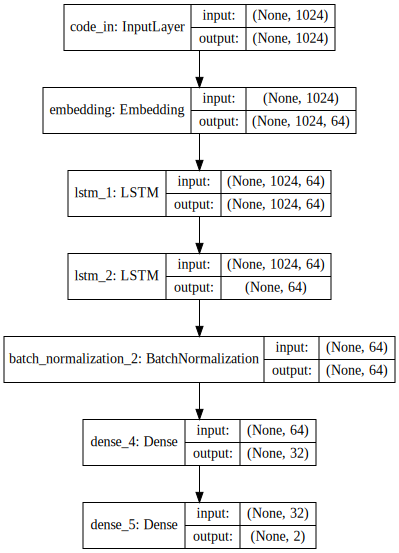

In [27]:
deeptune_noaux_model = DeepTuneNoAux()
deeptune_noaux_model.init(seed)
deeptune_noaux_model.model.summary()

img = None
if isnotebook():
    from keras.utils.vis_utils import model_to_dot
    from IPython.display import SVG
    img = SVG(model_to_dot(deeptune_noaux_model.model, show_shapes=True).create(prog='dot', format='svg'))
img

In [28]:
print("Evaluating DeepTune wo. auxiliary inputs ...", file=sys.stderr)
deeptune_noaux = evaluate(DeepTuneNoAux())
deeptune_noaux.groupby(['Platform', 'Benchmark Suite'])['Platform', 'Correct?', 'Speedup'].mean()

Evaluating DeepTune wo. auxiliary inputs ...
 70% (14 of 20) |#####################         | Elapsed Time: 0:00:00 ETA:  0:00:00

Correct?    Speedup
Platform        Benchmark Suite                     
AMD Tahiti 7970 AMD SDK          0.562500   0.904486
                NPB              0.645161   2.505454
                NVIDIA SDK       0.666667   3.669208
                Parboil          0.789474   6.275650
                Polybench        0.703704  13.915320
                Rodinia          0.580645   4.445974
                SHOC             0.833333   1.219326
NVIDIA GTX 970  AMD SDK          0.562500   0.710539
                NPB              0.812144   1.378846
                NVIDIA SDK       0.583333   0.981517
                Parboil          0.789474   1.458785
                Polybench        0.740741   1.151140
                Rodinia          0.580645   1.502166
                SHOC             0.708333   1.833715

Analysis of results. In the paper, we report that removing auxiliary inputs leads to a **12%** reduction in model accuracy:

In [29]:
speedup_loss = 1 - (deeptune_noaux['Speedup'].mean() / deeptune['Speedup'].mean())
acc_loss = 1 - (deeptune_noaux['Correct?'].mean() / deeptune['Correct?'].mean())

print(f"Training without auxiliary inputs yields a "
      f"{acc_loss:.0%} reduction in DeepTune's acccuracy, and a "
      f"{speedup_loss:.0%} reduction in performance.")

Training without auxiliary inputs yields a 12% reduction in DeepTune's acccuracy, and a 7% reduction in performance.


## 5. Seeding Transfer Learning

Now we train a DeepTune model which we will re-use in Case Study B by transferring the learned weights: 

In [30]:
print(f"Seeding transfer learning ... ", end="")

model_path = f"../data/case-study-b/case-study-a.model"
weights_path = f"../data/case-study-b/case-study-a-weights.h5"

if not fs.exists(weights_path):
    deeptune_model = DeepTune()

    if fs.exists(model_path):
        deeptune_model = deeptune_model.restore(model_path)
    else:
        df = pd.read_csv(f"../data/case-study-a/cgo17-amd.csv")

        sequences = encode_srcs(df["src"].values)

        features = grewe_features(df)
        aux_in = auxiliary_inputs(df)

        y = np.array([1 if x == "GPU" else 0 for x in df["oracle"].values])
        y_1hot = encode_1hot(y)

        deeptune_model.init(seed=seed)
        deeptune_model.train(df=df,
                             features=features,
                             aux_in=aux_in,
                             sequences=sequences,
                             y=y,
                             y_1hot=y_1hot,
                             verbose=True)
        deeptune_model.save(model_path)

    deeptune_model.model.save_weights(weights_path)

print("done.")

Seeding transfer learning ... done.


See '*Case Study B.ipynb*' for experiments using transfer learning.

End of experiments.